<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 3

</h4>

# Personal Data

In [2]:
# Set your student number
student_number = 400101204
Name = 'MohammadParsa'
Last_Name = 'Dini'

# Autoencoders (25 Points)

In this problem, you should implement an autoencoder network, which generates an image presenting the next digit of the input digit. Here are some examples:

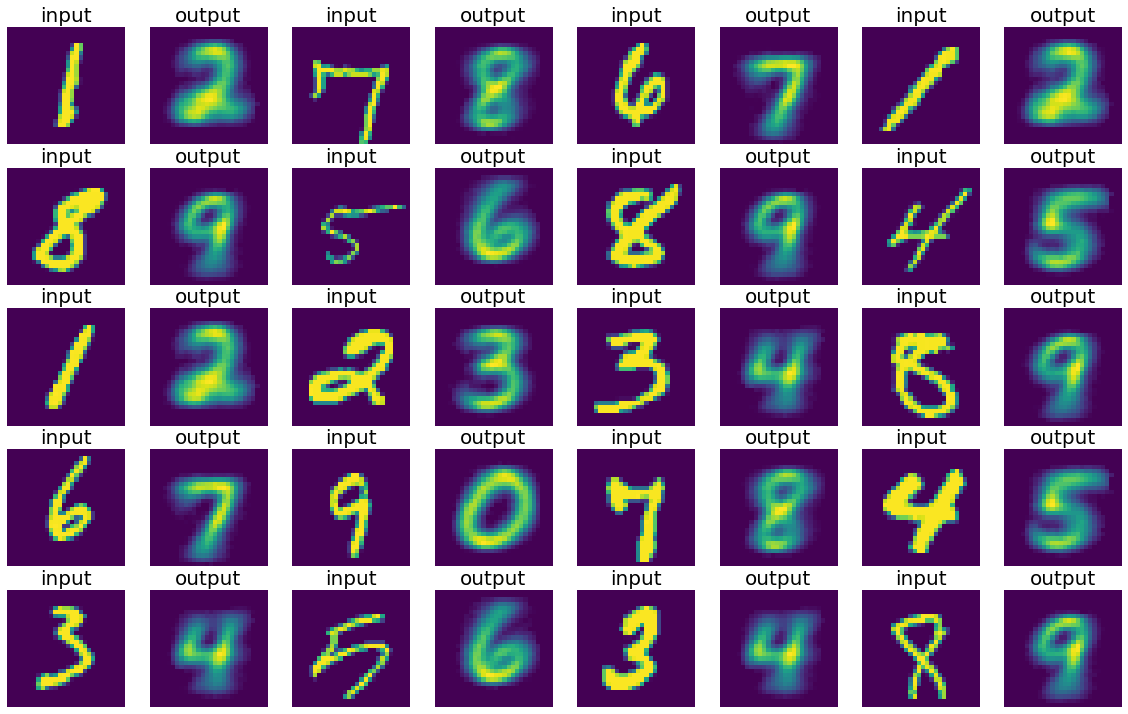

You should use the MNIST dataset, and the ground-truth for each example is provided by a helper function. Make sure to put the `ae_helper.py` file next to this notebook to use the helper function.

## Get the data

Get the data and split them into training, validation, and test sets, by running the following cell. `X` is the input images, `Y` is the ground-truth for each input, and `y` is the input's label.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ae_helper.py')

In [ ]:
from ae_helper import get_data
from sklearn.model_selection import train_test_split

X, Y, y = get_data()

X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(X, Y, y, test_size=0.2, random_state=17)
X_train, X_val, Y_train, Y_val, y_train, y_val = train_test_split(X_train, Y_train, y_train, test_size=0.1, random_state=17)

## Design your model

Please Implement your autoencoder model below. You MUST implement your model using the `torch` package. The model should input a batch of images and output the generated images for the whole batch. Your model can be consist of fully connected layers (using linear layers), but using fully-convolutional models has extra points.

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Define the encoder part of the autoencoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.ReLU()
        )

        # Define the decoder part of the autoencoder
        self.decoder = nn.Sequential(
            nn.Linear(10, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.ReLU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Save the original shape of the input
        shape = x.shape
        # Flatten the input tensor
        x = x.flatten(-2)
        # Pass the input through the encoder
        x = self.encoder(x)
        # Pass the encoded representation through the decoder
        x = self.decoder(x)
        # Reshape the output to the original input shape
        x = x.reshape(shape)
        return x


## The dataset class, and the dataloaders

The following cells implement the dataset class and create the data loaders for training and validation sets. Feel free to modify the batch size for each data loader.

In [ ]:
from typing import Tuple
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MnistNextDigitDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X).unsqueeze(1).float()
        self.Y = torch.from_numpy(Y).unsqueeze(1).float()
        self.y = torch.from_numpy(y)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, ...]:
        return self.X[i], self.Y[i], self.y[i]

In [ ]:
train_dataloader = DataLoader(
    MnistNextDigitDataset(X_train, Y_train, y_train),
    batch_size=512,
    shuffle=True
)
val_dataloader = DataLoader(
    MnistNextDigitDataset(X_val, Y_val, y_val),
    batch_size=1024,
    shuffle=False
)

In [ ]:
#### IMPLEMENT YOUR TRAIN/VAL LOOP ####

import os

# Directory to save the best model
save_dir = 'best_model'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Function to save the model
def save_model(model, epoch, loss):
    # Create the save path with the epoch number and loss value in the filename
    save_path = os.path.join(save_dir, f"autoencoder_epoch_{epoch}_loss_{loss:.4f}.pth")
    # Save the model's state dictionary
    torch.save(model.state_dict(), save_path)
    return save_path

num_epochs = 5  # Number of epochs to train the model
best_val_loss = float('inf')  # Initialize the best validation loss to infinity
best_model_path = ''  # Variable to store the path of the best model

for epoch in range(num_epochs):
    # Train the model for one epoch and get the training loss
    train_loss = train_autoencoder(ae, optimizer, train_dataloader)
    # Evaluate the model on the validation set and get the validation loss
    val_loss = eval_autoencoder(ae, val_dataloader)

    # Print the training and validation loss for the current epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Check if the current validation loss is the best we've seen so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss  # Update the best validation loss
        best_model_path = save_model(ae, epoch+1, val_loss)  # Save the model and update the best model path

# Print the path to the best model
print(f"Best model saved at: {best_model_path}")


## Instantiate the model and optimizer

Instantiate your model and optimizer in the following cell. Feel free to choose the optimizer and its configurations such as learning rate, decay, etc.

In [ ]:
#### INSTANTIATE YOUR MODEL AND OPTIMIZER ####

ae = AutoEncoder().to(device)
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)


## Train your autoencoder

Write your training/validation loop in the following cell for an arbitrary number of epochs (until convergence is detected). Make sure to use proper and readable logging containing training and validation metrics for each epoch. Select and store the state dictionary of the best epoch model according to the metrics.

In [ ]:
#### IMPLEMENT YOUR TRAIN/VAL LOOP ####

import os

# Directory to save the best model
save_dir = 'best_model'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Function to save the model
def save_model(model, epoch, loss):
    # Create the save path with the epoch number and loss value in the filename
    save_path = os.path.join(save_dir, f"autoencoder_epoch_{epoch}_loss_{loss:.4f}.pth")
    # Save the model's state dictionary
    torch.save(model.state_dict(), save_path)
    return save_path

num_epochs = 5  # Number of epochs to train the model
best_val_loss = float('inf')  # Initialize the best validation loss to infinity
best_model_path = ''  # Variable to store the path of the best model

for epoch in range(num_epochs):
    # Train the model for one epoch and get the training loss
    train_loss = train_autoencoder(ae, optimizer, train_dataloader)
    # Evaluate the model on the validation set and get the validation loss
    val_loss = eval_autoencoder(ae, val_dataloader)

    # Print the training and validation loss for the current epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Check if the current validation loss is the best we've seen so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss  # Update the best validation loss
        best_model_path = save_model(ae, epoch+1, val_loss)  # Save the model and update the best model path

# Print the path to the best model
print(f"Best model saved at: {best_model_path}")


Epoch 1/5, Train Loss: 0.0814, Validation Loss: 0.0740
Epoch 2/5, Train Loss: 0.0716, Validation Loss: 0.0688
Epoch 3/5, Train Loss: 0.0666, Validation Loss: 0.0642
Epoch 4/5, Train Loss: 0.0624, Validation Loss: 0.0611
Epoch 5/5, Train Loss: 0.0605, Validation Loss: 0.0604
Best model saved at: best_model\autoencoder_epoch_5_loss_0.0604.pth


## Load the state dictionary of the best epoch

Load the state dictionary of the best epoch model into the model object.

In [ ]:
#### LOAD THE BEST EPOCH STATE DICTIONARY ####


ae.load_state_dict(torch.load(best_model_path))
ae.eval()


AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=10, bias=True)
    (9): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=784, bias=True)
    (8): ReLU()
  )
)

## Visualize your model

Select 40 examples from the test set and visualize the input and output of the model for them (See the examples at the beginning of the notebook).

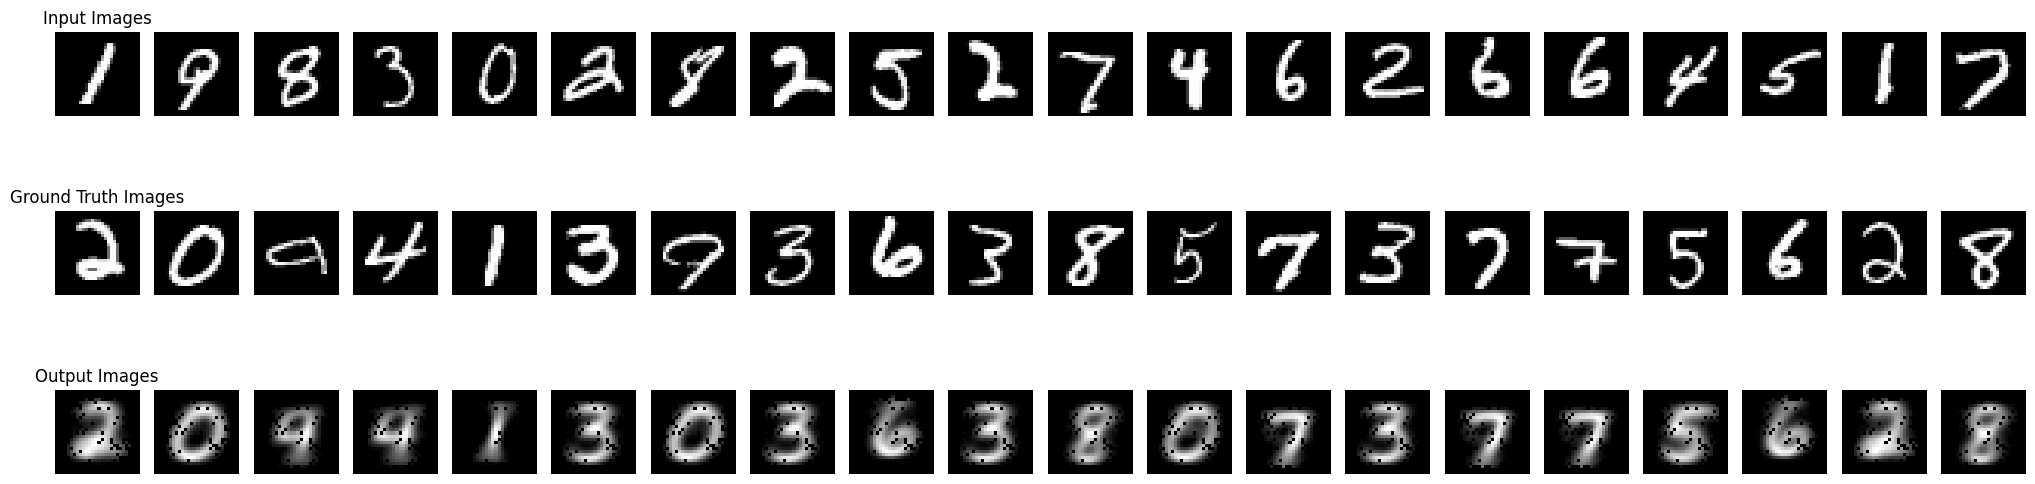

In [ ]:
#### VISUALIZE YOUR MODEL ####

import matplotlib.pyplot as plt

num_examples = 20  # Number of examples to visualize
X_test_tensor = torch.from_numpy(X_test[:num_examples]).unsqueeze(1).float().to(device)  # Convert and move input data to device
Y_test_tensor = torch.from_numpy(Y_test[:num_examples]).unsqueeze(1).float().to(device)  # Convert and move target data to device

# Model predictions
with torch.no_grad():  # Disable gradient computation
    Y_pred_tensor = ae(X_test_tensor)  # Get the model's predictions

# Convert tensors to numpy arrays for visualization
X_test_np = X_test_tensor.cpu().numpy()
Y_test_np = Y_test_tensor.cpu().numpy()
Y_pred_np = Y_pred_tensor.cpu().numpy()

# Create a figure with subplots
fig, axes = plt.subplots(nrows=3, ncols=num_examples, figsize=(20, 6))

for i in range(num_examples):
    # Original Input Image
    axes[0, i].imshow(X_test_np[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')  # Hide axes

    # True Image
    axes[1, i].imshow(Y_test_np[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')  # Hide axes

    # Reconstructed Image
    axes[2, i].imshow(Y_pred_np[i].reshape(28, 28), cmap='gray')
    axes[2, i].axis('off')  # Hide axes

# Set titles for the first column of each row
axes[0, 0].set_title('Input Images')
axes[1, 0].set_title('Ground Truth Images')
axes[2, 0].set_title('Output Images')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plot
